# 1c. Create master flats

In order to reduce the science images, we also need one `master_flat` for every filter. Individual exposures are organised in separate directories within `raw_flat_folder`.

## Initialise parameters

In [1]:
import os  # to manipulate files and directories
import numpy as np  # mathematics
from astropy.io import fits  # FITS files
from matplotlib import pyplot as plt  # plotting

data_folder = '.'  # location of the observational data within your hard disk (by default, this directory)
calib_folder = os.path.join(data_folder, 'raw', 'calib')  # location of the raw science exposures
raw_flat_folder = os.path.join(calib_folder, 'flat')  # location of the flat files

## Read master bias, dark, and flats

In [2]:
filename = os.path.join(calib_folder, 'master_bias.fits')
if os.path.isfile(filename):
    print("Opening", filename)
    hdu = fits.open(filename)
    bias = hdu[0].data
else:
    print(filename, 'not found: set bias=0')
    bias = 0.

Opening ./raw/calib/master_bias.fits


In [3]:
filename = os.path.join(calib_folder, 'master_dark.fits')
if os.path.isfile(filename):
    print("Opening", filename)
    hdu = fits.open(filename)
    dark = hdu[0].data
else:
    print(filename, 'not found: set dark=0')
    dark = 0.

./raw/calib/master_dark.fits not found: set dark=0


## Read raw exposures

Dive into the `raw_flat_folder` directory. Every folder in there should contain the raw flat exposures for a given filter. Read them all and store the data (normalized to the median value) in a dictionary, sorted by band.

In [4]:
flat_exposures = {}  # Dictionary containing all individual exposures

for foldername in os.listdir(raw_flat_folder):  # Loop over all files in the directory
    
    if os.path.isdir(os.path.join(raw_flat_folder, foldername)):
        print("Reading", foldername, "band flats:")
        flat_exposures[foldername] = []  # Empty list to store the exposures
        
        for filename in os.listdir(os.path.join(raw_flat_folder, foldername)):  # Loop over all files in the directory
            if os.path.splitext(filename)[1] == '.fits':  # FITS file extension
                print(" - Opening", filename)
                hdu = fits.open(os.path.join(raw_flat_folder, foldername, filename))  # HDU = Header/Data Unit (standard FITS nomenclature)
                # Add the data, normalized to their median, to the `flat_exposures` list of that band
                exposure = hdu[0].data - bias - dark*hdu[0].header['EXPTIME']
                flat_exposures[foldername].append(exposure/np.nanmedian(exposure))
                '''
                TODO:
                - show individual exposures?
                '''
            else:
                print(" - Skipping", filename)
        
        n_files = len(flat_exposures[foldername])
        print(" -", n_files, "files read for", foldername, "band")

    else:
        print(foldername+" is not a directory")

Reading B band flats:
 - Opening uamA_0043.fits
 - 1 files read for B band
Reading V band flats:
 - Opening uamA_0048.fits
 - 1 files read for V band


## Compute master flats

For every band, output the median flat

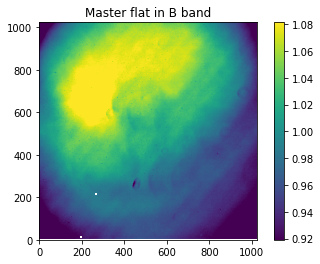

Master flat saved to ./raw/calib/master_flat_B.fits


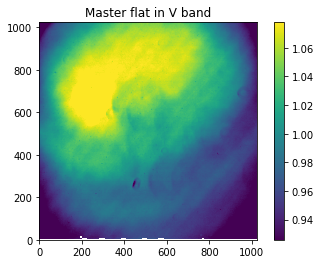

Master flat saved to ./raw/calib/master_flat_V.fits


In [26]:
for band in flat_exposures:
    n_files = len(flat_exposures[band])

    if n_files == 0:
        raise FileNotFoundError("No FITS files were found in "+band+" band")

    else:
        flat_map = np.nanmedian(flat_exposures[band], axis=0)
        bad_flat = np.abs(flat_map-1) > 5*np.nanstd(flat_map)  # sigma-clipping *TODO*: less arbitrary!
        flat_map[bad_flat] = np.nan
        plt.imshow(flat_map, origin='lower', vmin=np.nanpercentile(flat_map, 5), vmax=np.nanpercentile(flat_map, 95))
        plt.title('Master flat in '+band+' band')
        plt.colorbar()
        plt.show()
        output_filename = os.path.join(calib_folder, 'master_flat_'+band+'.fits')
        hdu = fits.PrimaryHDU(flat_map)
        hdu.writeto(output_filename, overwrite=True)
        print("Master flat saved to", output_filename)